Copyright 2018 Tobias Jachowski

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [189]:
%matplotlib nbagg
from matplotlib import pyplot as plt
import os
import tifffile
from ipywidgets import interact, IntSlider
from IPython.core.display import Image, display
from matplotlib.widgets import SpanSelector
import numpy as np
import imageio
import time
import pathlib


def file_and_dir(filename=None, directory=None):
    filename = filename or ""
    fdir = os.path.dirname(filename)
    ffile = os.path.basename(filename)

    ddir = directory or "."

    if (ffile == "" or ffile == "." or ffile == ".."):
        directory = os.path.join(ddir, filename, "")
        absdir = os.path.realpath(directory)
        return None, absdir, None

    directory = os.path.join(ddir, fdir, "")
    absdir = os.path.realpath(directory)
    absfile = os.path.join(absdir, ffile)

    return ffile, absdir, absfile

def files(directory, prefix=None, suffix=None, extension=None, sort_key=None):
    """
    Get filenames of a directory in the order sorted to their filename or a
    given key function.

    Parameters
    ----------
    directory : str
        The directory the files are located in.
    prefix : str
        Get only the files beginning with `prefix`.
    suffix : str
        Get only the files ending with `suffix`.
    extension : str, optional
        The extension of the files that should be returned. Default is
        '.txt'.
    sort_key : function
        Function to be applied to every filename found, before sorting.
    """
    prefix = prefix or ''
    suffix = suffix or ''
    extension = extension or ''
    files = [file_and_dir(filename=name, directory=directory)[2]
             for name in os.listdir(directory)
             if os.path.isfile(os.path.join(directory, name))
             and name.startswith(prefix)
             and name.endswith(''.join((suffix, extension)))]
    files.sort(key=sort_key)
    return files

def dtype_info(dtype=None, array=None):
    if array is not None:
        dtype = dtype or array.dtype
    try:
        info = np.iinfo(dtype)
    except:
        info = np.finfo(dtype)
    return dtype, info

def lookup_table(dtype, minimum=None, maximum=None, dtype_to=None):
    dtype, info = dtype_info(dtype=dtype)
    dtype_to = dtype_to or dtype
    dtype_to, info_to = dtype_info(dtype=dtype_to)

    minimum = minimum or info.min
    maximum = maximum or info.max
    minimum = max(minimum, info.min)
    maximum = min(maximum, info.max)
    
    # Create a lookup table 
    lut = np.zeros(2**info.bits, dtype=dtype_to)
    lut[:minimum] = info_to.min
    lut[minimum:maximum + 1] = np.linspace(info_to.min, info_to.max, maximum - minimum + 1, dtype=dtype_to)
    lut[maximum:] = info_to.max

    return lut

def adjust_contrast(image, min, max):
    dtype = image.dtype
    lut = lookup_table(dtype, min, max)
    return np.take(lut, image)

def convert_image(image, dtype_to, min, max):
    dtype = image.dtype
    lut = lookup_table(dtype, min, max, dtype_to)
    return np.take(lut, image)

def convert_uin16_uint8(image, minimum=None, maximum=None, width=None):
    if width is not None:
        # adjust histogramm according to given width, centered around the median
        #hist, values = np.histogram(im, bins=2**16-1)
        #middle = hist.argmax()
        median = np.median(image)
        minimum = median - width / 2
        maximum = median + width / 2 - minimum
    else:
        minimum = minimum or image.min()
        maximum = maximum or image.max()
        maximum -= minimum
    return convert_image(image, minimum, maximum, 'uint8')

class adjust_image_contrast(object):
    def __init__(self, image=None, dtype=None):
        """
        Display images of a directory with an interactive widget and a slider in a
        jupyter notebook, in the order sorted to their filename or a given key
        function.

        Parameters
        ----------
        image : np.ndarray
        dtype : np.ndarray.dtype
        """
        if dtype is not None or image is not None:
            dtype, info = dtype_info(array=image, dtype=dtype)
            self.min = info.min
            self.max = info.max
        else:
            self.min = None
            self.max = None

        self.fig, axes = plt.subplots(nrows=2, ncols=2)
        self.axes = axes.flatten()
        
        self.image = None
        if image is not None:
            self.process_image(image)

    def __call__(self, image=None):
        self.process_image(image)

    def process_image(self, image=None):
        if image is None:
            image = self.image
        else:
            self.image = image
            self.axes[0].clear()    
            self.axes[0].imshow(image, cmap=plt.cm.gray)
            self.axes[2].clear()
            self.axes[2].hist(image.ravel(), bins=(2**8 - 1))
            self.spanselector = SpanSelector(self.axes[2], self.set_min_max_hist,
                                             'horizontal', useblit=True)
            self.axspan = self.axes[2].axvspan(self.min, self.max,
                                               facecolor='y', alpha=0.2)

        self.axes[1].clear()
        self.axes[3].clear()
        self.image_contrast = adjust_contrast(image, self.min, self.max)
        im_c = self.image_contrast
        self.axes[1].imshow(im_c, cmap=plt.cm.gray)
        self.axes[3].hist(im_c.ravel(), bins=(2**8 - 1))
    
    def set_min_max_hist(self, minimum, maximum):
        """
        Set the timespan according to the SpanSelector and update the figure
        accordingly. Call all registered callback functions.

        This function is called upon any change of the SpanSelector.

        Parameters
        ----------
        min : float
        max : float
        """
        self.min = int(np.round(minimum))
        self.max = int(np.round(maximum))
        try:
            dtype, info = dtype_info(array=self.image)
            self.min = max(self.min, info.min)
            self.max = min(self.max, info.max)
        except:
            pass
        self.axspan.set_xy([[minimum, 0],  # lower left corner
                            [minimum, 1],  # upper left corner
                            [maximum, 1],  # upper right corner
                            [maximum, 0],  # lower right corner
                            [minimum, 0]])  # lower left corner
        self.process_image()

class process_images(object):
    def __init__(self, process, directory, prefix=None, suffix=None, extension='.png',
                 sort_key=None, idx_r=None, idx_c=None):
        """
        Display images of a directory with an interactive widget and a slider in a
        jupyter notebook, in the order sorted to their filename or a given key
        function.

        Parameters
        ----------
        process : function
            function, which takes an image (np.ndarray) as an argument
        directory : str
            The directory the images to be displayed are located in.
        prefix : str
            Display only the files beginning with `prefix`.
        suffix : str
            Display only the files ending with `suffix`.
        extension : str, optional
            The extension of the images that should be displayed. Default is
            '.png'.
        sort_key : function
            Function to be applied to every image filename found, before sorting.
        """
        self.images = files(directory, prefix, suffix, extension, sort_key)
        self.process = process
        self.idx_r = idx_r or slice(None)
        self.idx_c = idx_c or slice(None)

        stop = len(self.images)
        if stop < 1:
            print("No file found with prefix '%s', suffix '%s', and extension '%s'"
                  % (prefix, suffix, extension))
            return

        slider = IntSlider(min=0, max=stop-1, step=1, value=0,
                           description='Image:')
        
        def process_image(i):
            self.process_image(i)

        self.interact = interact(process_image, i=slider)
    
    def process_image(self, i):
        image = self.images[i]
        try:
            print(image)
            try:
                im = imageio.imread(image)
            except:
                im = tifffile.imread(image)
            self.process(im[self.idx_r, self.idx_c])
        except:
            print('No image found!')

def filterby(files, prefix=None, suffix=None, extension=None):
    prefix = prefix or ''
    suffix = suffix or ''
    extension = extension or ''
    for file in files:
        if file.startswith(prefix) and file.endswith(''.join((suffix, extension))):
            yield file

def scalebar(image, resolution, pos_x_rel=0.96, pos_y_rel=0.96, width=1, height=0.1, value=None):
    width_px = int(np.round(width / resolution))
    height_px = int(np.round(height / resolution))
    
    image_height, image_width = image.shape
    pos_x = int(np.round(pos_x_rel * image_width))
    pos_y = int(np.round(pos_y_rel * image_height))
    
    dtype, info = dtype_info(array=image)
    value = value or info.max
    
    image[pos_y - height_px:pos_y, pos_x - width_px:pos_x] = value

<IPython.core.display.Javascript object>


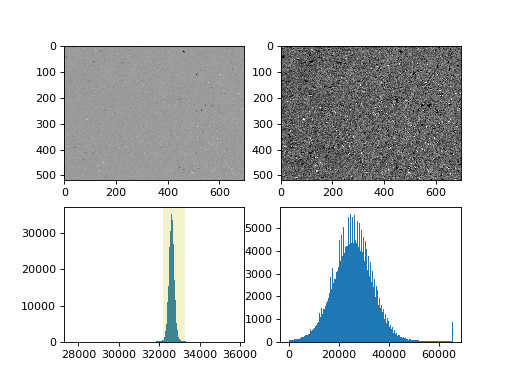

interactive(children=(IntSlider(value=0, description='Image:', max=174), Output()), _dom_classes=('widget-interact',))

In [142]:
# Find the right contrast
directory = '../images/S20'
prefix = 'S20'

extension = '.tif'

cp = adjust_image_contrast()
pi = process_images(cp, directory, prefix=prefix, extension=extension)

In [143]:
minimum, maximum = cp.min, cp.max
# minimum, maximum = 61668, 65102  # S00, S00
# minimum, maximum = 30636, 34818  # S01, S01
# minimum, maximum = 31733, 33703  # S02, S02
# minimum, maximum = 32149, 33233  # S03, S03
# minimum, maximum = 61018, 64954  # S04, S04
# minimum, maximum = 32138, 33353  # S05, S05
# minimum, maximum = 32389, 33627  # S10, S100
# minimum, maximum = 32452, 33481  # S10, S101
# minimum, maximum = 32578, 33218  # S10, S102
# minimum, maximum = 32567, 35707  # S11, S110
# minimum, maximum = 32258, 33300  # S11, S111
# minimum, maximum = 60474, 64060  # S11, S112
# minimum, maximum = 32408, 33252  # S11, S114
# minimum, maximum = 32369, 33262  # S11, S115
# minimum, maximum = 60505, 64198  # S11, S116
# minimum, maximum = 60914, 64634  # S12, S120
# minimum, maximum = 31559, 34062  # S12, S121
# minimum, maximum = 31512, 34056  # S12, S122
# minimum, maximum = 31284, 34247  # S13, S130
# minimum, maximum = 62109, 65535  # S13, S131
# minimum, maximum = 31491, 34028  # S13, S132
# minimum, maximum = 31411, 34252  # S13, S133
# minimum, maximum = 31445, 34056  # S13, S134
# minimum, maximum = 31478, 34147  # S13, S135
# minimum, maximum = 31314, 34128  # S13, S136
# minimum, maximum = 31186, 34243  # S14, S140
# minimum, maximum = 31304, 34197  # S14, S141
# minimum, maximum = 60681, 65535  # S14, S142
# minimum, maximum = 32184, 33294  # S20, S20
cp.min, cp.max = minimum, maximum
print('# minimum, maximum = {}, {}  # {}, {}'.format(minimum, maximum, os.path.basename(directory), prefix))

# minimum, maximum = 32184, 33294  # S20, S20


In [138]:
videosuffix = '.mp4'
fps = None
resolution = 78  # nm/px

for root, dirs, filenames in os.walk(directory):
    filenames = list(filterby(filenames, prefix=prefix, extension=extension))
    if len(filenames) > 2:
        print('Creating Video of files in {} ...'.format(root))
        def creation_time(filename):
            fullname = os.path.join(root, filename)
            return os.stat(fullname).st_mtime

        filenames.sort(key=creation_time)
        start_time = os.stat(os.path.join(root, filenames[0])).st_mtime
        end_time = os.stat(os.path.join(root, filenames[-1])).st_mtime
        duration = end_time - start_time
        _fps = fps or (len(filenames) - 1) / duration
        print('Frames per second: {:.2f}'.format(_fps))

        videoname = ''.join((prefix, videosuffix))
        savename = os.path.join(root, '..', videoname)
        writer = imageio.get_writer(savename, fps=_fps)# pixelformat='gray16le')

        for filename in filenames:
            fullname = os.path.join(root, filename)
            #im = imageio.imread(fullname, format='tif', multifile=False)
            im = tifffile.imread(fullname)
            #scalebar(im, resolution, width=500, height=50)
            #width = cp.max - cp.min
            #print('Width in grey values: {:.1f}'.format(width))
            #im = convert_uin16_uint8(im, width=width)
            im = convert_image(im, 'uint8', cp.min, cp.max)
            writer.append_data(im)

        writer.close()
        print('... Created video {}.'.format(videoname))

Creating Video of files in ../images/S20 ...
Frames per second: 2.38
... Created video S20.mp4.


In [ ]:
# OLD FUNCTIONS

"""
def lookup_table(dtype, min=None, max=None):
    dtype, info = dtype_info(dtype=dtype)

    min = min or info.min
    max = max or info.max
    max = max - min

    lut = np.arange(info.min, info.max + 1, dtype=float)
    lut -= min
    lut *= info.max / max
    lut = np.round(lut)
    lut[lut < info.min] = info.min
    lut[lut > info.max] = info.max
    return lut.astype(dtype)
"""

"""
def convert_uin16_uint8(image, minimum=None, maximum=None, width=None):
    if width is not None:
        # adjust histogramm according to given width, centered around the median
        #hist, values = np.histogram(im, bins=2**16-1)
        #middle = hist.argmax()
        median = np.median(image)
        minimum = median - width / 2
        maximum = median + width / 2 - minimum
    else:
        minimum = minimum or image.min()
        maximum = maximum or image.max()
        maximum -= minimum
    im_brightness = image - minimum
    im_contrast = im_brightness / maximum * 255
    im_contrast[im_contrast < 0] = 0
    im_contrast[im_contrast > 255] = 255
    return im_contrast.round().astype('uint8')
"""

